In [12]:
# generate synthetic handwriting based on a target handwriting
# implementation based on the research from Haines, Aodha, and Brostow 2016.
# https://researchportal.bath.ac.uk/en/publications/my-text-in-your-handwriting

# Author: Rachael Williams
# Last Update: 2/25/23

In [14]:
import numpy as np
import cv2
# note about opencv: it uses BGR color format
#!pip install imutils
import imutils
#from imutils.contours import sort_contours

from google.colab import drive
from google.colab.patches import cv2_imshow

# accessing files from Google Drive
drive.mount("/content/drive", force_remount=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


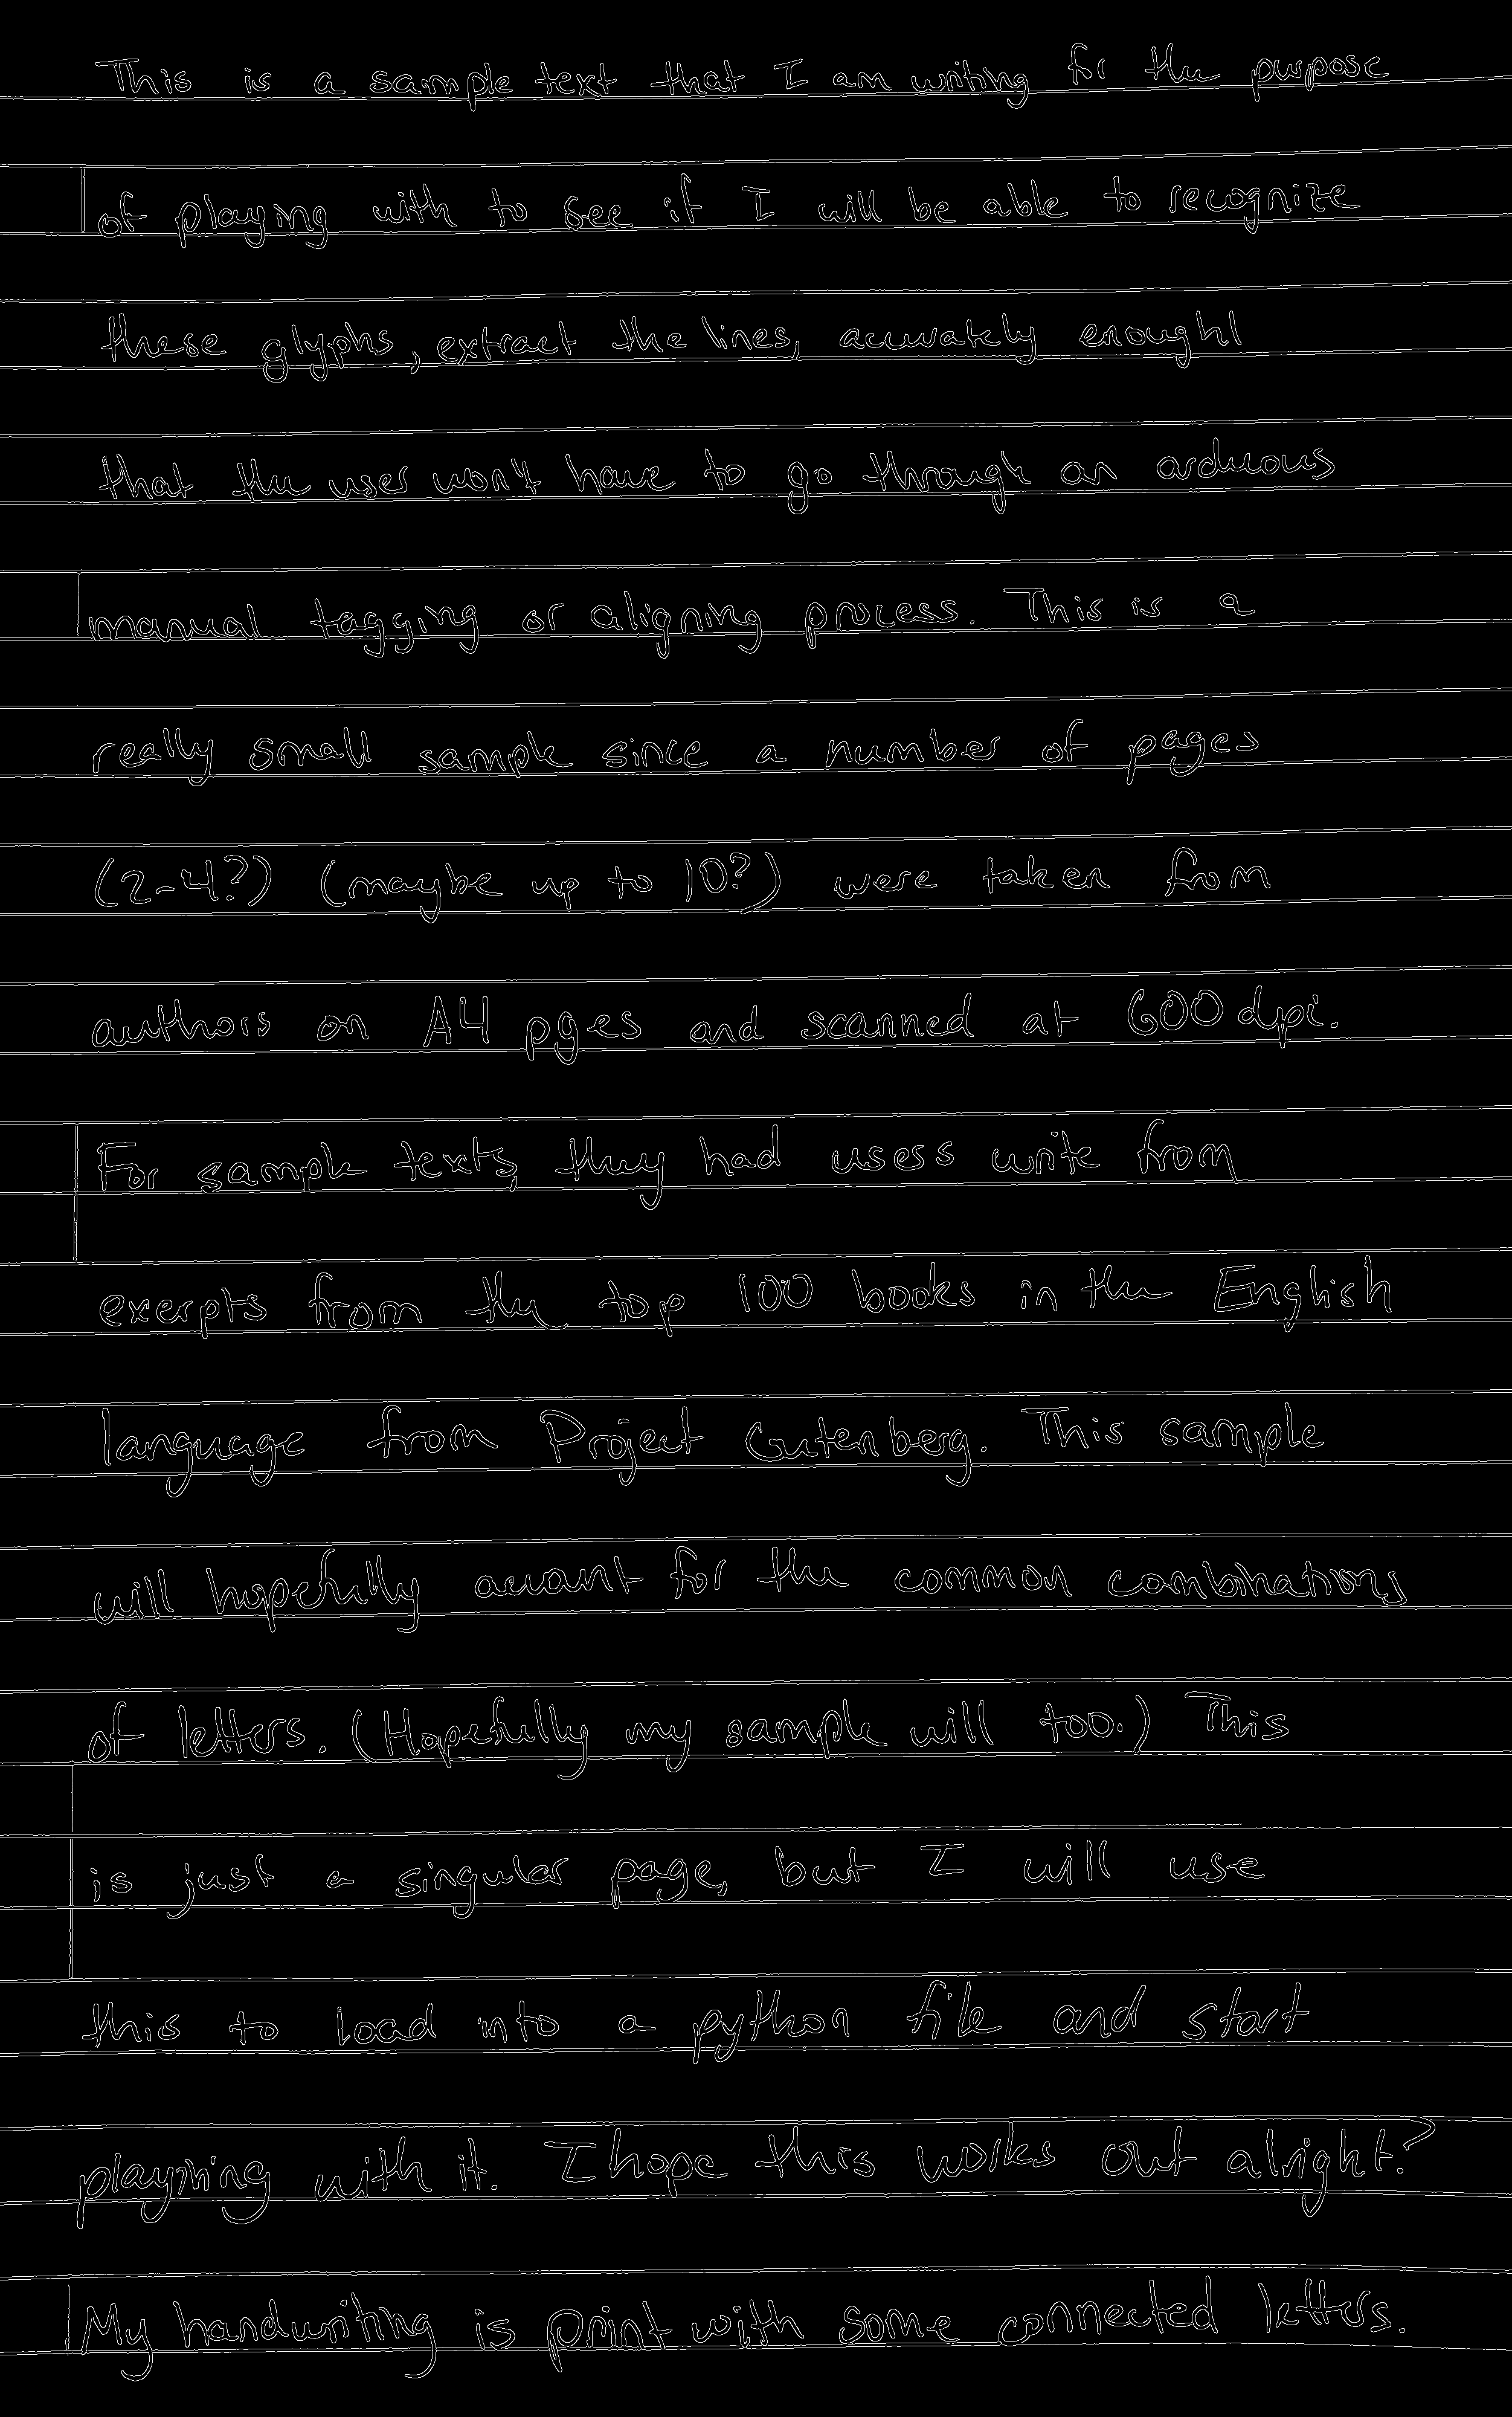

In [24]:
text_random = '/content/drive/MyDrive/ColabNotebooks/CS98/LinedTextSample_Random.jpg'
# the random text is a ramble of my random thoughts to simulate people's notes
# (still double-spaced to keep it simple for now)

text_fixed = '/content/drive/MyDrive/ColabNotebooks/CS98/LinedTextSample_Frankenstein.jpg'
# the fixed text is an excerpt from Mary Shelley's Frankenstein found on Project Gutenberg
# for automatic glyph tagging, we might want to use a standard text.
# we might want to write one ourself in the spirit of Dreamworld Carnival: https://www.extensis.com/blog/my-quest-to-make-authentic-looking-handwriting-fonts
# or we might want to scrape public domain texts from Project Gutenberg

im_random = cv2.imread(text_random)

# display an image
def im_display(im, s=0, colab=False):
    """
    Function to encapsulate the steps to show an image using OpenCV.

    Inputs: 
        - im: image loaded from cv2.imread
        - s: number of milliseconds to display the image
             0 means to keep the image up until the user closes it
        - colab: boolean False if running a .py file, True if using Google Colab
        note: if you are using Jupyter Notebook, this function won't work

    Output:
        - none, no return value
    """
    
    # cv2.imshow causes Google Colab to crash, but cv2_imshow is a patch
    # specficially to be used with the Colab environment
    if colab:
        cv2_imshow(im)
    else:
        cv2.imshow("image display", im)
    
    cv2.waitKey(s)
    cv2.destroyAllWindows()

# ink extraction

# Strategy 1: Assign Ink Levels to Every Pixel (Haines et. al method)
# assume pixels depict either paper or ink color
# worse option: assume binary color space and use Gaussian kernel to identify the two largest colors in the image
# better option: line ink replacement
# this will allow any writing implements (e.g. pen, pencil, etc.) to be inputted or outputted.
# how to do this:
# pass an line through both modes from the Gaussian kernel
# the paper is treated as 0 and the ink color is treated at strength 1
# the halfway point which marks the boundary between ink and paper is treated as 0 (paper)
# linear interpolation maps every pixel to an ink level

# Strategy 2: Feature Detection (Rachael method)
def detect_edges(im):
    """
    Function to detect edges in an image.

    Input: image loaded from cv2.imread
    
    Output: edges, an image edge map
    """
    # grayscale the image
    im_gray = cv2.imread(text_random, 0)  # 0 is the same as cv2.IMREAD_GRAYSCALE

    # perform Gaussian blurring to reduce noise
    im_blur = cv2.GaussianBlur(im_gray, (5, 5), 0)

    # perform edge detection
    edges = cv2.Canny(im_blur, 30, 150)
    im_display(edges, 0, True)
    return edges

    # find contours in the edge map
    #contours = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #contours = imutils.grab_contours(contours)
    # sort contours from left-to-right, for reading the glyphs
    #contours = imutils.contours.sort_contours(contours, method="left-to-right")[0]

detect_edges(im_random)


# Strategy 1b / 2b: Remove Lines from Paper using Houghline Method, then do Strategy 1 or 2
# https://www.geeksforgeeks.org/line-detection-python-opencv-houghline-method/
